# 🗣️ Conversational RAG using a Chat Message Store

_by [Sebastian Husch Lee](https://www.linkedin.com/in/sebastian-husch-lee) and [Vladimir Blagojevic](https://www.linkedin.com/in/blagojevicvladimir)_

In this notebook, we'll show how to incorporate a conversational history into a RAG pipeline to enable multi-turn conversations with our documents, using our experimental components: `InMemoryChatMessageStore`, `ChatMessageRetriever`, and `ChatMessageWriter`.

## Installation

Install Haystack, `haystack-experimental` and `datasets` with pip:

In [ ]:
!pip install -U "haystack-experimental>=0.15.0" datasets

## Enter OpenAI API key

In [5]:
import os
from getpass import getpass

if "OPENAI_API_KEY" not in os.environ:
    os.environ["OPENAI_API_KEY"] = getpass("Enter OpenAI API key:")

Enter OpenAI API key: ········


## Conversational Pipeline

- Just show basic setup with new components plus Chat Generator to do multi-turn conversations
- Highlight how the `chat_history_id` can be used to manage session histories 

## Conversational RAG

- This is to highlight how we can incorporate RAG into our conversational pipeline

### Create a Document Store and Index Documents

Create an index with [seven-wonders](https://huggingface.co/datasets/bilgeyucel/seven-wonders) dataset:

In [23]:
from haystack import Document
from haystack.components.retrievers.in_memory import InMemoryBM25Retriever
from haystack.document_stores.in_memory import InMemoryDocumentStore
from datasets import load_dataset

dataset = load_dataset("bilgeyucel/seven-wonders", split="train")
docs = [Document(content=doc["content"], meta=doc["meta"]) for doc in dataset]

document_store = InMemoryDocumentStore()
document_store.write_documents(documents=docs)

151

### Create a Chat Message Store

The conversation history is saved as `ChatMessage` objects in a `InMemoryChatMessageStore`. You can retrieve the conversation history from the chat message store using `ChatMessageRetriever`.

To store the conversation history, initialize an `InMemoryChatMessageStore`, a `ChatMessageRetriever` and a `ChatMessageWriter`. Import these components from the [`haystack-experimental`](https://github.com/deepset-ai/haystack-experimental) package:

In [24]:
from haystack_experimental.chat_message_stores.in_memory import InMemoryChatMessageStore
from haystack_experimental.components.retrievers import ChatMessageRetriever
from haystack_experimental.components.writers import ChatMessageWriter

# Chat History components
memory_store = InMemoryChatMessageStore()
memory_retriever = ChatMessageRetriever(memory_store)
memory_writer = ChatMessageWriter(memory_store)

### Build the Pipeline

- Add components for RAG and chat history retreival and storage to build your pipeline.
- Incorporate an `OutputAdapter` component into your pipeline to handle messages from both the user and the LLM, writing them to the memory store.
- The previous conversation history will be retrieved by `ChatMessageRetriever` from the `InMemoryChatMessageStore` given a `chat_history_id`.

In [25]:
from typing import List
from haystack import Pipeline
from haystack.components.builders import ChatPromptBuilder, PromptBuilder
from haystack.components.converters import OutputAdapter
from haystack.components.generators.chat import OpenAIChatGenerator
from haystack.components.generators import OpenAIGenerator
from haystack.dataclasses import ChatMessage


pipeline = Pipeline()

# Create the system and user message
system_message = ChatMessage.from_system(
    "You are a helpful AI assistant that answers users questions grounded in a set supporting documents."
)
user_message_template ="""Give a brief answer to the question grounded in the supporting documents.
If question can't be answered from supporting documents, say so.

Supporting documents:
{%- if documents|length > 0 %}
{%- for doc in documents %}
Document [{{ loop.index }}] :
{{ doc.content }}
{% endfor -%}
{%- else %}
No relevant documents found.
{% endif %}

Question: {{query}}
Answer:
"""
user_message = ChatMessage.from_user(user_message_template)

# components for RAG
pipeline.add_component("doc_retriever", InMemoryBM25Retriever(document_store=document_store, top_k=3))
pipeline.add_component(
    "prompt_builder", ChatPromptBuilder(template=[system_message, user_message], required_variables="*")
)
pipeline.add_component("llm", OpenAIChatGenerator())

# components for chat history retrieval and storage
pipeline.add_component("message_retriever", memory_retriever)
pipeline.add_component("message_writer", memory_writer)
pipeline.add_component(
    "message_joiner",
    OutputAdapter(template="{{ prompt + replies }}", output_type=list[ChatMessage], unsafe=True)
)

# connections
pipeline.connect("doc_retriever.documents", "prompt_builder.documents")
pipeline.connect("prompt_builder.prompt", "message_retriever.current_messages")
pipeline.connect("prompt_builder.prompt", "message_joiner.prompt")
pipeline.connect("message_retriever.messages", "llm.messages")
pipeline.connect("llm.replies", "message_joiner.replies")
pipeline.connect("message_joiner", "message_writer.messages")

Unsafe mode is enabled. This allows execution of arbitrary code in the Jinja template. Use this only if you trust the source of the template.


🚅 Components
  - doc_retriever: InMemoryBM25Retriever
  - prompt_builder: ChatPromptBuilder
  - llm: OpenAIChatGenerator
  - message_retriever: ChatMessageRetriever
  - message_writer: ChatMessageWriter
  - message_joiner: OutputAdapter
🛤️ Connections
  - doc_retriever.documents -> prompt_builder.documents (list[Document])
  - prompt_builder.prompt -> message_retriever.current_messages (list[ChatMessage])
  - prompt_builder.prompt -> message_joiner.prompt (list[ChatMessage])
  - llm.replies -> message_joiner.replies (list[ChatMessage])
  - message_retriever.messages -> llm.messages (list[ChatMessage])
  - message_joiner.output -> message_writer.messages (list[ChatMessage])

### Visualize the pipeline

Visualize the pipeline with the [`show()`](https://docs.haystack.deepset.ai/docs/visualizing-pipelines) method to confirm the connections are correct.

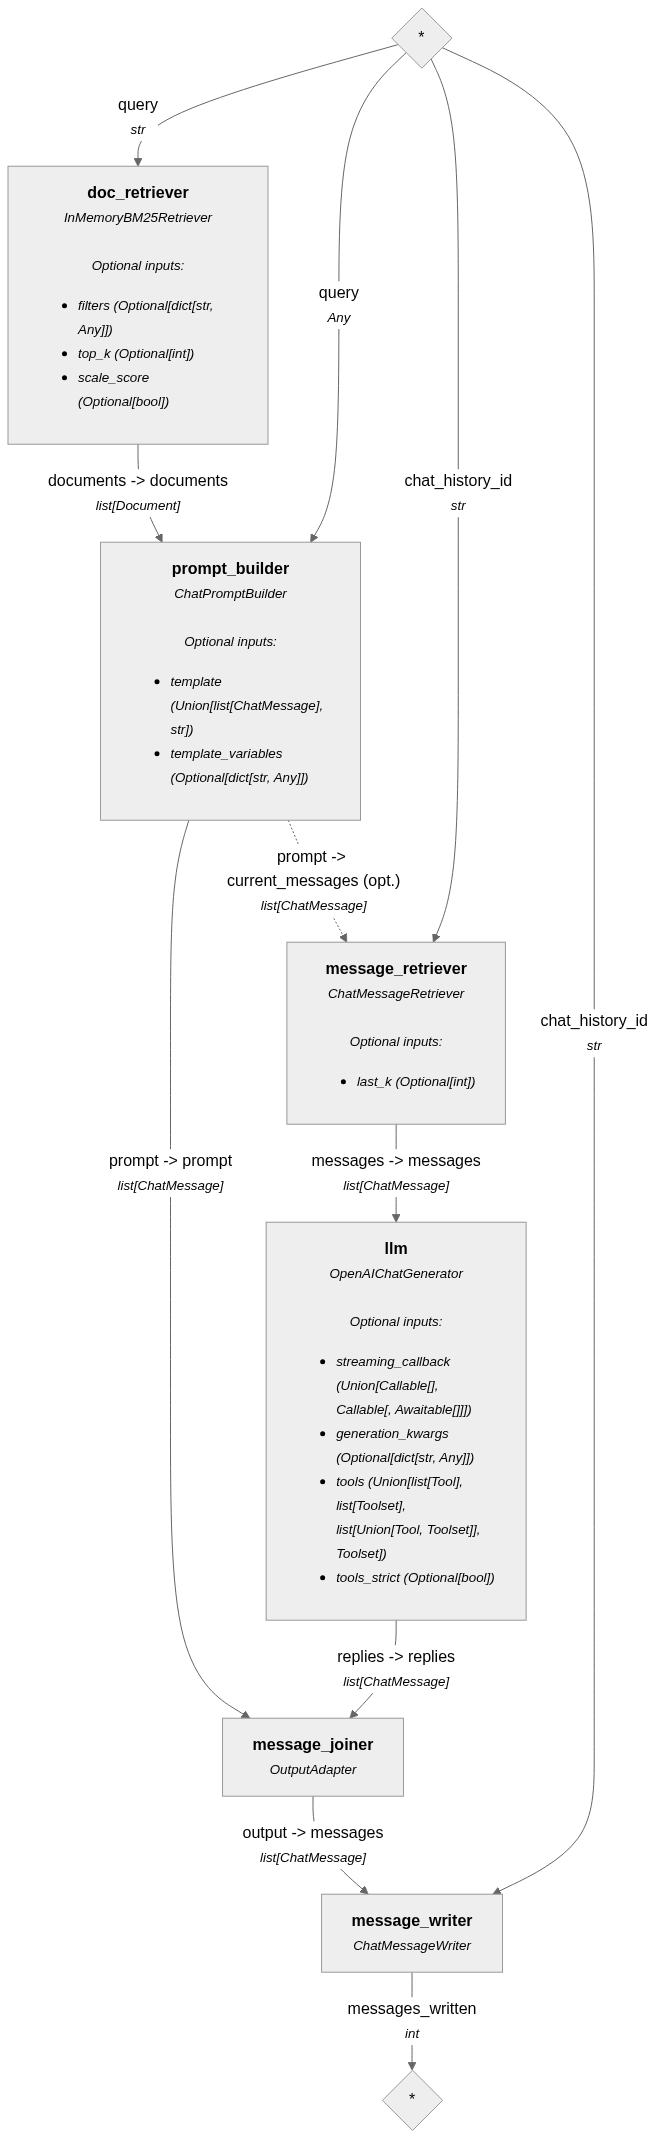

In [22]:
pipeline.show()

### Run the Pipeline

- Test the pipeline with some queries. 
- Ensure that in every request we add a `chat_history_id` parameter so that we know which conversational history we'd like to retrieve and write to.

Here are example queries you can try:

* *What does Rhodes Statue look like?*
* *Who built it?*

In [27]:
chat_history_id = "user_123_session_1"

while True:
    question = input("Enter your question or Q to exit.\n🧑 ")
    if question == "Q":
        break

    res = pipeline.run(
        data={
            "doc_retriever": {"query": question},
            "prompt_builder": {"query": question},
            "message_retriever": {"chat_history_id": question},
            "message_writer": {"chat_history_id": question},
        },
        include_outputs_from={"llm"}
    )
    assistant_resp = res["llm"]["replies"][0]
    print(f"🤖 {assistant_resp.text}")

Enter your question or Q to exit.
🧑  What does Rhodes Statue look like?


🤖 Scholars do not know the Colossus’ full appearance. It represented Helios; the head and face are thought to have had curly hair with evenly spaced bronze or silver spikes (a radiating “sun” crown) like images on contemporary Rhodian coins. Anecdotes of it straddling the harbour lack historical/scientific support.


Enter your question or Q to exit.
🧑  Who built it?


🤖 Which monument do you mean?

- Hanging Gardens of Babylon: legend credits Neo‑Babylonian King Nebuchadnezzar II.  
- Mausoleum at Halicarnassus: it was the tomb of Mausolus — construction was begun by/for Mausolus (continued after his death) and, per Vitruvius, built by the architects Satyros and Pytheus (and traditionally finished by his wife).


Enter your question or Q to exit.
🧑  Q


⚠️ If you followed the example queries, you'll notice that the second question was answered incorrectly. This happened because the retrieved documents weren't relevant to the user's query. The retrieval was based on the query "*Who built it?*", which doesn't have enough context to retrieve documents.

**TODO**: Perhaps this is the better segue into using Agent. Much easier to setup the query-rephrasing. 
- Let's fix it with **rephrasing the query for search**.

## Conversational Agent with a RAG Tool

### Create RAG Tool

In conversational systems, simply pre-pending the chat history to the new user message is not enough to perform RAG effectively. There needs to be a mechanism to rephrase the user's query based on the conversation history to ensure relevant documents are retrieved. For instance, if the first user query is "*What's the first name of Einstein?*" and the second query is "*Where was he born?*", the system should understand that "he" refers to Einstein. The rephrasing mechanism should then modify the second query to "*Where was Einstein born?*" to retrieve the correct documents.

We can use an LLM to rephrase the user's query. Let's create a prompt that instructs the LLM to rephrase the query, incorporating the conversation history, to make it suitable for retrieving relevant documents.

In [11]:
query_rephrase_template = """
Rewrite the question for search while keeping its meaning and key terms intact.
If there is no conversation history, DO NOT change the query.
Use conversation history only if necessary, and avoid extending the query with your own knowledge.
If no changes are needed, output the current question as is.

User Query: {{query}}
Rewritten Query:
"""

### Build the Conversational RAG Agent Pipeline

Now, let's incorporate query rephrasing into our pipeline by adding a new [ChatPromptBuilder](https://docs.haystack.deepset.ai/docs/chatpromptbuilder) with the prompt above, [OpenAIChatGenerator](https://docs.haystack.deepset.ai/docs/openaichatgenerator), and an [OutputAdapter](https://docs.haystack.deepset.ai/docs/outputadapter). The `OpenAIChatGenerator` will rephrase the user's query for search, and the `OutputAdapter` will convert the output from the `OpenAIChatGenerator` into the input for the `InMemoryBM25Retriever`. The rest of the pipeline will be the same.

In [12]:
from typing import List
from haystack import Pipeline
from haystack.components.builders import ChatPromptBuilder
from haystack.components.generators.chat import OpenAIChatGenerator
from haystack.components.converters import OutputAdapter

conversational_rag = Pipeline()

# components for query rephrasing
conversational_rag.add_component(
    "query_rephrase_prompt_builder", ChatPromptBuilder(template=ChatMessage.from_user(query_rephrase_template))
)
conversational_rag.add_component("query_rephrase_llm", OpenAIChatGenerator())
conversational_rag.add_component(
    "list_to_str_adapter", OutputAdapter(template="{{ replies[0].text }}", output_type=str)
)

# components for RAG
conversational_rag.add_component(
    "doc_retriever", InMemoryBM25Retriever(document_store=document_store, top_k=3)
)
conversational_rag.add_component(
    "prompt_builder", ChatPromptBuilder(template=[system_message, user_message], required_variables="*")
)
conversational_rag.add_component("llm", OpenAIChatGenerator())

# components for chat history storage and retrieval
conversational_rag.add_component("message_retriever", ChatMessageRetriever(memory_store))
conversational_rag.add_component("message_writer", ChatMessageWriter(memory_store))
conversational_rag.add_component(
    "message_joiner",
    OutputAdapter(template="{{ prompt + replies }}", output_type=list[ChatMessage], unsafe=True)
)

# connections for query rephrasing
conversational_rag.connect("query_rephrase_prompt_builder.prompt", "message_retriever.current_messages")
conversational_rag.connect("message_retriever.messages", "query_rephrase_llm.prompt")
conversational_rag.connect("query_rephrase_llm.replies", "list_to_str_adapter")
conversational_rag.connect("list_to_str_adapter", "doc_retriever.query")

# connections for RAG
conversational_rag.connect("doc_retriever.documents", "prompt_builder.documents")
conversational_rag.connect("prompt_builder.prompt", "llm.messages")
conversational_rag.connect("llm.replies", "memory_joiner")

# connections for chat history storage and retreival
conversational_rag.connect("memory_joiner", "memory_writer")
conversational_rag.connect("memory_retriever", "prompt_builder.memories")

🚅 Components
  - query_rephrase_prompt_builder: PromptBuilder
  - query_rephrase_llm: OpenAIGenerator
  - list_to_str_adapter: OutputAdapter
  - retriever: InMemoryBM25Retriever
  - prompt_builder: ChatPromptBuilder
  - llm: OpenAIChatGenerator
  - memory_retriever: ChatMessageRetriever
  - memory_writer: ChatMessageWriter
  - memory_joiner: ListJoiner
🛤️ Connections
  - query_rephrase_prompt_builder.prompt -> query_rephrase_llm.prompt (str)
  - query_rephrase_llm.replies -> list_to_str_adapter.replies (List[str])
  - list_to_str_adapter.output -> retriever.query (str)
  - retriever.documents -> prompt_builder.documents (List[Document])
  - prompt_builder.prompt -> llm.messages (List[ChatMessage])
  - llm.replies -> memory_joiner.values (List[ChatMessage])
  - memory_retriever.messages -> query_rephrase_prompt_builder.memories (List[ChatMessage])
  - memory_retriever.messages -> prompt_builder.memories (List[ChatMessage])
  - memory_joiner.values -> memory_writer.messages (List[ChatMes

### Let's have a conversation 😀

Now, run the pipeline with the relevant inputs. Instead of sending the query directly to the `retriever`, this time, pass it to the `query_rephrase_prompt_builder` to rephrase it.

Here are some example queries and follow ups you can try:

* *What does Rhodes Statue look like?* - *Who built it?* - *Did he destroy it?*
* *Where is Gardens of Babylon?* - *When was it built?*

In [14]:
while True:
    question = input("Enter your question or Q to exit.\n🧑 ")
    if question == "Q":
        break

    res = conversational_rag.run(
        data={
            "query_rephrase_prompt_builder": {"query": question},
            "prompt_builder": {"query": question},
        },
        include_outputs_from={"llm","query_rephrase_llm"}
    )
    search_query = res["query_rephrase_llm"]["replies"][0]
    print(f"   🔎 Search Query: {search_query}")
    assistant_resp = res["llm"]["replies"][0]
    print(f"🤖 {assistant_resp.text}")

Enter your question or Q to exit.
🧑 Where is Gardens of Babylon? 
   🔎 Search Query: Where are the Hanging Gardens of Babylon located?
🤖 The Hanging Gardens of Babylon were said to be located in the ancient city of Babylon, near present-day Hillah, Babil province, in Iraq.
Enter your question or Q to exit.
🧑 When was it built?
   🔎 Search Query: When was the Hanging Gardens of Babylon built?
🤖 The Hanging Gardens of Babylon are said to have been built during the reign of King Nebuchadnezzar II, who ruled between 605 and 562 BC.
Enter your question or Q to exit.
🧑 Q


✅ Notice that this time, with the help of query rephrasing, we've built a conversational RAG pipeline that can handle follow-up queries and retrieve the relevant documents.